## MNIST digit Classification
1. Using only numpy
2. Keras tensorflow model

In [1]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from keras.datasets import mnist

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [8]:
def plot_digit(img, dim, font_size=8):
    max_ax = font_size * dim
    fig = plt.figure(figsize=(10, 10))
    plt.xlim([0, max_ax])
    plt.ylim([0, max_ax])
    plt.axis('off')
    
    for i in range(dim):
        for j in range(dim):
            t = plt.text(i * font_size, max_ax - j * font_size, img[j][i], 
                         fontsize=font_size, color='black')
            c = img[j][i] / 255.   # RGBA values should be within 0-1 range
            t.set_bbox(dict(facecolor=(c, c, c), alpha=0.3, edgecolor='black'))

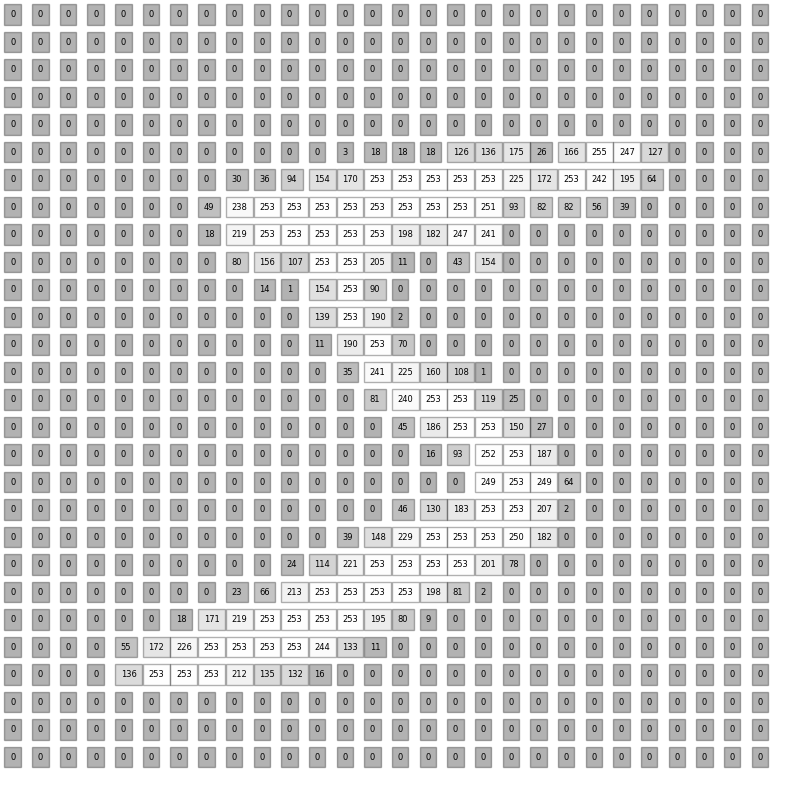

In [9]:
plot_digit(X_train[0], 28, 6)

In [3]:
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
print(X_train.shape)
print(X_test.shape)

(60000, 784)
(10000, 784)


In [4]:
X_train = X_train.T
X_test = X_test.T
print(X_train.shape)
print(X_test.shape)

(784, 60000)
(784, 10000)


### Derivative of Softmax
https://math.stackexchange.com/questions/945871/derivative-of-softmax-loss-function

**Derivative of Cost function w.r.t Z (output) - softmax**:

$$\frac{\partial{J}}{\partial{Z^{[L]}}} = A^{[L]} - y$$

In [12]:
class NN_clf():
    def __init__(self):
        # Kaiming He initialization for the weights
        self.W1 = np.random.randn(10, 784) * np.sqrt(2/784)
        self.b1 = np.zeros((10, 1))
        self.W2 = np.random.randn(10, 10) * np.sqrt(2/10)
        self.b2 = np.zeros((10, 1))

    def relu(self, Z):
        return np.maximum(0, Z)

    def deriv_relu(self, Z):
        return (Z > 0).astype(int)

    def softmax(self, Z):
        e_z = np.exp(Z - np.max(Z))
        return e_z / e_z.sum(axis=0)

    def one_hot(self, y):
        n_classes = len(np.unique(y_train))
        y_oh = np.eye(n_classes)[y]
        return y_oh.T

    def forward_prop(self, X):
        self.Z1 = np.matmul(self.W1, X) + self.b1
        self.A1 = self.relu(self.Z1)
        self.Z2 = np.matmul(self.W2, self.A1) + self.b2
        self.A2 = self.softmax(self.Z2)

    def backward_prop(self, X, y):
        m = y.size
        y_oh = self.one_hot(y)
        dZ2 = self.A2 - y_oh  # gradient of the Loss function (cross entropy) w.r.t Z2, see note: Derivative Softmax
        self.dW2 = (1/m) * np.matmul(dZ2, self.A1.T)
        self.db2 = (1/m) * np.sum(dZ2, axis=1).reshape(-1, 1)
        dZ1 = np.matmul(self.W2.T, dZ2) * self.deriv_relu(self.Z1)
        self.dW1 = (1/m) * np.matmul(dZ1, X.T)
        self.db1 = (1/m) * np.sum(dZ1, axis=1).reshape(-1, 1)

    def update_params(self, lr):
        self.W2 -= lr * self.dW2
        self.b2 -= lr * self.db2
        self.W1 -= lr * self.dW1
        self.b1 -= lr * self.db1

    def predict(self):
        return np.argmax(self.A2, axis=0)

    def accuracy(self, prediction, y):
        return np.sum(prediction == y) / y.size

    def fit(self, X, y, lr, n_iters):
        for i in range(n_iters):
            self.forward_prop(X)
            self.backward_prop(X, y)
            self.update_params(lr)
            if i % 20 == 0:
                print('Iteration:', i)
                print(self.accuracy(self.predict(), y))
        print('Model accuracy:', self.accuracy(self.predict(), y)) 

In [13]:
nn = NN_clf()
nn.fit(X_train, y_train, 0.1, 200) 

Iteration: 0
0.14273333333333332
Iteration: 20
0.5049666666666667
Iteration: 40
0.6501666666666667
Iteration: 60
0.7582166666666666
Iteration: 80
0.8185333333333333
Iteration: 100
0.84
Iteration: 120
0.8529166666666667
Iteration: 140
0.8626666666666667
Iteration: 160
0.8696333333333334
Iteration: 180
0.8753333333333333
Model accuracy: 0.8797666666666667


### Minibatches, Adam optimizer

In [15]:
class NN_clf():
    def __init__(self):
        # Kaiming He initialization for the weights
        self.W1 = np.random.randn(256, 784) * np.sqrt(2/784)
        self.b1 = np.zeros((256, 1))
        self.W2 = np.random.randn(10, 256) * np.sqrt(2/256)
        self.b2 = np.zeros((10, 1))

    def init_adam(self):
        self.v = {}
        self.s = {}
        self.v['dW1'] = np.zeros((256, 784))
        self.v['db1'] = np.zeros((256, 1))
        self.s['dW1'] = np.zeros((256, 784))
        self.s['db1'] = np.zeros((256, 1))

        self.v['dW2'] = np.zeros((10, 256))
        self.v['db2'] = np.zeros((10, 1))
        self.s['dW2'] = np.zeros((10, 256))
        self.s['db2'] = np.zeros((10, 1))

    def relu(self, Z):
        return np.maximum(0, Z)

    def deriv_relu(self, Z):
        return (Z > 0).astype(int)

    def softmax(self, Z):
        e_z = np.exp(Z - np.max(Z))
        return e_z / e_z.sum(axis=0)

    def one_hot(self, y):
        n_classes = len(np.unique(y_train))
        y_oh = np.eye(n_classes)[y]
        return y_oh.T

    def forward_prop(self, X):
        self.Z1 = np.matmul(self.W1, X) + self.b1
        self.A1 = self.relu(self.Z1)
        self.Z2 = np.matmul(self.W2, self.A1) + self.b2
        self.A2 = self.softmax(self.Z2)

    def backward_prop(self, X, y):
        m = y.size
        y_oh = self.one_hot(y)
        dZ2 = self.A2 - y_oh  # gradient of the Loss function (cross entropy) w.r.t Z2, see note: Derivative Softmax
        self.dW2 = (1/m) * np.matmul(dZ2, self.A1.T)
        self.db2 = (1/m) * np.sum(dZ2, axis=1).reshape(-1, 1)
        dZ1 = np.matmul(self.W2.T, dZ2) * self.deriv_relu(self.Z1)
        self.dW1 = (1/m) * np.matmul(dZ1, X.T)
        self.db1 = (1/m) * np.sum(dZ1, axis=1).reshape(-1, 1)

    def update_params(self, lr):
        self.W2 -= lr * self.dW2
        self.b2 -= lr * self.db2
        self.W1 -= lr * self.dW1
        self.b1 -= lr * self.db1

    def update_params_with_adam(self, t, lr=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.v_corrected = {}
        self.s_corrected = {}

        # moving average of the gradients
        self.v['dW2'] = beta1 * self.v['dW2'] + (1-beta1) * self.dW2
        self.v['db2'] = beta1 * self.v['db2'] + (1-beta1) * self.db2
    
        # moving average of the squared gradients
        self.s['dW2'] = beta2 * self.s['dW2'] + (1-beta2) * np.square(self.dW2)
        self.s['db2'] = beta2 * self.s['db2'] + (1-beta2) * np.square(self.db2)
    
        # bias-corrected first moment estimate
        self.v_corrected['dW2'] = self.v['dW2'] / (1 - np.power(beta1, t))
        self.v_corrected['db2'] = self.v['db2'] / (1 - np.power(beta1, t))
    
        # bias-corrected second moment estimate
        self.s_corrected['dW2'] = self.s['dW2'] / (1 - np.power(beta2, t))
        self.s_corrected['db2'] = self.s['db2'] / (1 - np.power(beta2, t))
    
        # update parameters
        self.W2 -= lr * self.v_corrected['dW2'] / (np.sqrt(self.s_corrected['dW2']) + epsilon)
        self.b2 -= lr * self.v_corrected['db2'] / (np.sqrt(self.s_corrected['db2']) + epsilon)

        # moving average of the gradients
        self.v['dW1'] = beta1 * self.v['dW1'] + (1-beta1) * self.dW1
        self.v['db1'] = beta1 * self.v['db1'] + (1-beta1) * self.db1
    
        # moving average of the squared gradients
        self.s['dW1'] = beta2 * self.s['dW1'] + (1-beta2) * np.square(self.dW1)
        self.s['db1'] = beta2 * self.s['db1'] + (1-beta2) * np.square(self.db1)
    
        # bias-corrected first moment estimate
        self.v_corrected['dW1'] = self.v['dW1'] / (1 - np.power(beta1, t))
        self.v_corrected['db1'] = self.v['db1'] / (1 - np.power(beta1, t))
    
        # bias-corrected second moment estimate
        self.s_corrected['dW1'] = self.s['dW1'] / (1 - np.power(beta2, t))
        self.s_corrected['db1'] = self.s['db1'] / (1 - np.power(beta2, t))
    
        # update parameters
        self.W1 -= lr * self.v_corrected['dW1'] / (np.sqrt(self.s_corrected['dW1']) + epsilon)
        self.b1 -= lr * self.v_corrected['db1'] / (np.sqrt(self.s_corrected['db1']) + epsilon)


    def predict(self, X):
        self.forward_prop(X)
        return np.argmax(self.A2, axis=0)

    def accuracy(self, prediction, y):
        return np.sum(prediction == y) / y.size

    def random_mini_batches(self, X, y, mini_batch_size=64, seed=0):
        np.random.seed(seed)
        m = X.shape[1]
        mini_batches = []
    
        # step 1: shuffle (X, y)
        permutation = list(np.random.permutation(m))
        X_shuffled = X[:, permutation]
        y_shuffled = y[permutation]
    
        # step 2: partition (shuffle_X, shuffle_y), handle the end case
        n_batches = math.floor(m / mini_batch_size)
        for k in range(n_batches):
            mini_batch_X = X_shuffled[:, k*mini_batch_size:(k+1)*mini_batch_size]
            mini_batch_y = y_shuffled[k*mini_batch_size:(k+1)*mini_batch_size]
            mini_batches.append((mini_batch_X, mini_batch_y))
    
        if m % mini_batch_size != 0:
            mini_batch_X = X_shuffled[:, int(m/mini_batch_size)*mini_batch_size:]
            mini_batch_y = y_shuffled[int(m/mini_batch_size)*mini_batch_size:]
            mini_batches.append((mini_batch_X, mini_batch_y))  
        return mini_batches 


    def fit(self, X, y, mini_batch_size, lr, n_epochs):
        seed = 10
        m = X.shape[1]
        self.init_adam()
        t = 0    # adam counter
        for i in range(n_epochs):
            seed += 1
            t += 1
            minibatches = self.random_mini_batches(X, y, mini_batch_size, seed)
            for minibatch in minibatches:
                #t += 1
                X_minibatch, y_minibatch = minibatch
                self.forward_prop(X_minibatch)
                self.backward_prop(X_minibatch, y_minibatch)
                self.update_params_with_adam(t, lr)
                
            if i % 10 == 0:
                preds = self.predict(X)
                acc = self.accuracy(preds, y)
                print('Accuracy on training data after epoch %i: %f' % (i, acc))
    
        preds = self.predict(X)
        print('\nModel accuracy on training data:', self.accuracy(preds, y))

In [16]:
nn = NN_clf()     # 784 - 256 - 10
nn.fit(X_train, y_train, 512, 0.005, 30)

Accuracy on training data after epoch 0: 0.963350
Accuracy on training data after epoch 10: 0.996500
Accuracy on training data after epoch 20: 0.999683

Model accuracy on training data: 0.9999833333333333


In [17]:
preds = nn.predict(X_test)
nn.accuracy(preds, y_test)

0.9824

### Add Dropout

In [8]:
class NN_clf():
    def __init__(self):
        # Kaiming He initialization for the weights
        self.W1 = np.random.randn(256, 784) * np.sqrt(2/784)
        self.b1 = np.zeros((256, 1))
        self.W2 = np.random.randn(10, 256) * np.sqrt(2/256)
        self.b2 = np.zeros((10, 1))

    def init_adam(self):
        self.v = {}
        self.s = {}
        self.v['dW1'] = np.zeros((256, 784))
        self.v['db1'] = np.zeros((256, 1))
        self.s['dW1'] = np.zeros((256, 784))
        self.s['db1'] = np.zeros((256, 1))

        self.v['dW2'] = np.zeros((10, 256))
        self.v['db2'] = np.zeros((10, 1))
        self.s['dW2'] = np.zeros((10, 256))
        self.s['db2'] = np.zeros((10, 1))

    def relu(self, Z):
        return np.maximum(0, Z)

    def deriv_relu(self, Z):
        return (Z > 0).astype(int)

    def softmax(self, Z):
        e_z = np.exp(Z - np.max(Z))
        return e_z / e_z.sum(axis=0)

    def one_hot(self, y):
        n_classes = len(np.unique(y_train))
        y_oh = np.eye(n_classes)[y]
        return y_oh.T
    
    def forward_prop_with_dropout(self, X, keep_prob):
        self.Z1 = np.matmul(self.W1, X) + self.b1
        self.A1 = self.relu(self.Z1)
        self.D1 = np.random.rand(self.A1.shape[0], self.A1.shape[1])    # different units will get shut off with different call (don't use seed here)
        self.D1 = (self.D1 < keep_prob).astype(int)
        self.A1 = self.A1 * self.D1
        self.A1 = self.A1 / keep_prob
        self.Z2 = np.matmul(self.W2, self.A1) + self.b2
        self.A2 = self.softmax(self.Z2)

    def backward_prop_with_dropout(self, X, y, keep_prob):
        m = y.size
        y_oh = self.one_hot(y)
        dZ2 = self.A2 - y_oh  # gradient of the Loss function (cross entropy) w.r.t Z2, see note: Derivative Softmax
        self.dW2 = (1/m) * np.matmul(dZ2, self.A1.T)
        self.db2 = (1/m) * np.sum(dZ2, axis=1).reshape(-1, 1)
        
        dA1 = np.dot(self.W2.T, dZ2)
        dA1 = dA1 * self.D1
        dA1 = dA1 / keep_prob     
        dZ1 = dA1 * self.deriv_relu(self.A1)
        self.dW1 = (1/m) * np.matmul(dZ1, X.T)
        self.db1 = (1/m) * np.sum(dZ1, axis=1).reshape(-1, 1)


    def update_params_with_adam(self, t, lr=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.v_corrected = {}
        self.s_corrected = {}

        # moving average of the gradients
        self.v['dW2'] = beta1 * self.v['dW2'] + (1-beta1) * self.dW2
        self.v['db2'] = beta1 * self.v['db2'] + (1-beta1) * self.db2
    
        # moving average of the squared gradients
        self.s['dW2'] = beta2 * self.s['dW2'] + (1-beta2) * np.square(self.dW2)
        self.s['db2'] = beta2 * self.s['db2'] + (1-beta2) * np.square(self.db2)
    
        # bias-corrected first moment estimate
        self.v_corrected['dW2'] = self.v['dW2'] / (1 - np.power(beta1, t))
        self.v_corrected['db2'] = self.v['db2'] / (1 - np.power(beta1, t))
    
        # bias-corrected second moment estimate
        self.s_corrected['dW2'] = self.s['dW2'] / (1 - np.power(beta2, t))
        self.s_corrected['db2'] = self.s['db2'] / (1 - np.power(beta2, t))
    
        # update parameters
        self.W2 -= lr * self.v_corrected['dW2'] / (np.sqrt(self.s_corrected['dW2']) + epsilon)
        self.b2 -= lr * self.v_corrected['db2'] / (np.sqrt(self.s_corrected['db2']) + epsilon)

        # moving average of the gradients
        self.v['dW1'] = beta1 * self.v['dW1'] + (1-beta1) * self.dW1
        self.v['db1'] = beta1 * self.v['db1'] + (1-beta1) * self.db1
    
        # moving average of the squared gradients
        self.s['dW1'] = beta2 * self.s['dW1'] + (1-beta2) * np.square(self.dW1)
        self.s['db1'] = beta2 * self.s['db1'] + (1-beta2) * np.square(self.db1)
    
        # bias-corrected first moment estimate
        self.v_corrected['dW1'] = self.v['dW1'] / (1 - np.power(beta1, t))
        self.v_corrected['db1'] = self.v['db1'] / (1 - np.power(beta1, t))
    
        # bias-corrected second moment estimate
        self.s_corrected['dW1'] = self.s['dW1'] / (1 - np.power(beta2, t))
        self.s_corrected['db1'] = self.s['db1'] / (1 - np.power(beta2, t))
    
        # update parameters
        self.W1 -= lr * self.v_corrected['dW1'] / (np.sqrt(self.s_corrected['dW1']) + epsilon)
        self.b1 -= lr * self.v_corrected['db1'] / (np.sqrt(self.s_corrected['db1']) + epsilon)


    def predict(self, X):
        self.forward_prop_with_dropout(X, keep_prob=1)
        return np.argmax(self.A2, axis=0)

    def accuracy(self, prediction, y):
        return np.sum(prediction == y) / y.size

    def loss(self, y):
        epsilon = 1e-5
        loss = np.sum((-y * np.log(self.A2 + epsilon)), axis=0)
        loss = np.mean(loss)
        return loss

    def random_mini_batches(self, X, y, mini_batch_size=64, seed=0):
        np.random.seed(seed)
        m = X.shape[1]
        mini_batches = []
    
        # step 1: shuffle (X, y)
        permutation = list(np.random.permutation(m))
        X_shuffled = X[:, permutation]
        y_shuffled = y[permutation]
    
        # step 2: partition (shuffle_X, shuffle_y), handle the end case
        n_batches = math.floor(m / mini_batch_size)
        for k in range(n_batches):
            mini_batch_X = X_shuffled[:, k*mini_batch_size:(k+1)*mini_batch_size]
            mini_batch_y = y_shuffled[k*mini_batch_size:(k+1)*mini_batch_size]
            mini_batches.append((mini_batch_X, mini_batch_y))
    
        if m % mini_batch_size != 0:
            mini_batch_X = X_shuffled[:, int(m/mini_batch_size)*mini_batch_size:]
            mini_batch_y = y_shuffled[int(m/mini_batch_size)*mini_batch_size:]
            mini_batches.append((mini_batch_X, mini_batch_y))  
        return mini_batches 


    def fit(self, X, y, mini_batch_size, lr, n_epochs, keep_prob=0.7):
        history = {'epochs': [], 'loss': [], 'accuracy': []}
        seed = 10
        m = X.shape[1]
        self.init_adam()
        t = 0    # adam counter
        step = 1
        print('epoch:', end=' ')
        for i in range(n_epochs):
            seed += 1
            t += 1
            minibatches = self.random_mini_batches(X, y, mini_batch_size, seed)
            for minibatch in minibatches:
                X_minibatch, y_minibatch = minibatch
                self.forward_prop_with_dropout(X_minibatch, keep_prob)
                self.backward_prop_with_dropout(X_minibatch, y_minibatch, keep_prob)
                self.update_params_with_adam(t, lr)
                
                if step % 1 == 0:
                    loss = self.loss(y_minibatch)
                    acc = self.accuracy(np.argmax(self.A2, axis=0), y_minibatch)
                    history['epochs'].append(i+1)
                    history['loss'].append(loss)
                    history['accuracy'].append(acc)
                step += 1
            print(i+1, end=' ')
                
        preds = self.predict(X)
        print('\nModel accuracy on training data:', self.accuracy(preds, y))
        return history

In [19]:
nn = NN_clf()
hist = nn.fit(X_train, y_train, mini_batch_size=512, lr=0.005, n_epochs=30, keep_prob=0.6) 

epoch: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 
Model accuracy on training data: 0.99785


In [20]:
preds = nn.predict(X_test)
nn.accuracy(preds, y_test)

0.982

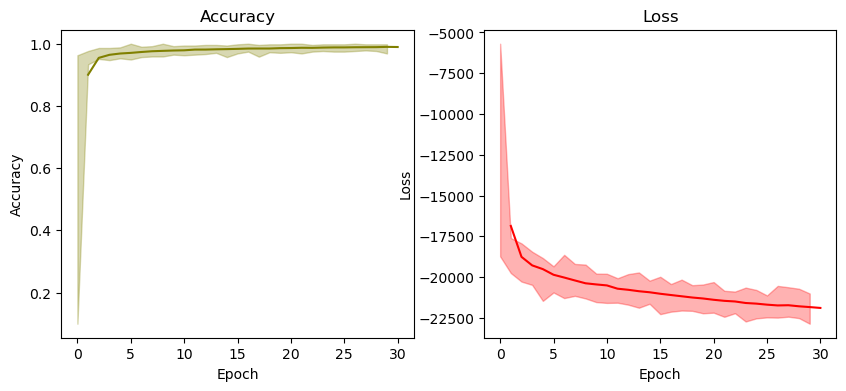

In [21]:
df_hist = pd.DataFrame(hist)
df_hist_grouped = df_hist.groupby('epochs').agg(['mean', 'min', 'max'])
acc = df_hist_grouped['accuracy']['mean']
acc_min = df_hist_grouped['accuracy']['min']
acc_max = df_hist_grouped['accuracy']['max']

loss = df_hist_grouped['loss']['mean']
loss_min = df_hist_grouped['loss']['min']
loss_max = df_hist_grouped['loss']['max']

plt.figure(figsize=(10, 4))
#plt.style.use('grayscale')
plt.subplot(1, 2, 1)
plt.plot(acc, color='olive')
plt.fill_between(range(len(acc)), acc_min, acc_max, color='olive', alpha=0.3)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, color='red')
plt.fill_between(range(len(loss)), loss_min, loss_max, color='red', alpha=0.3)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss');

### With Keras - LeNet5

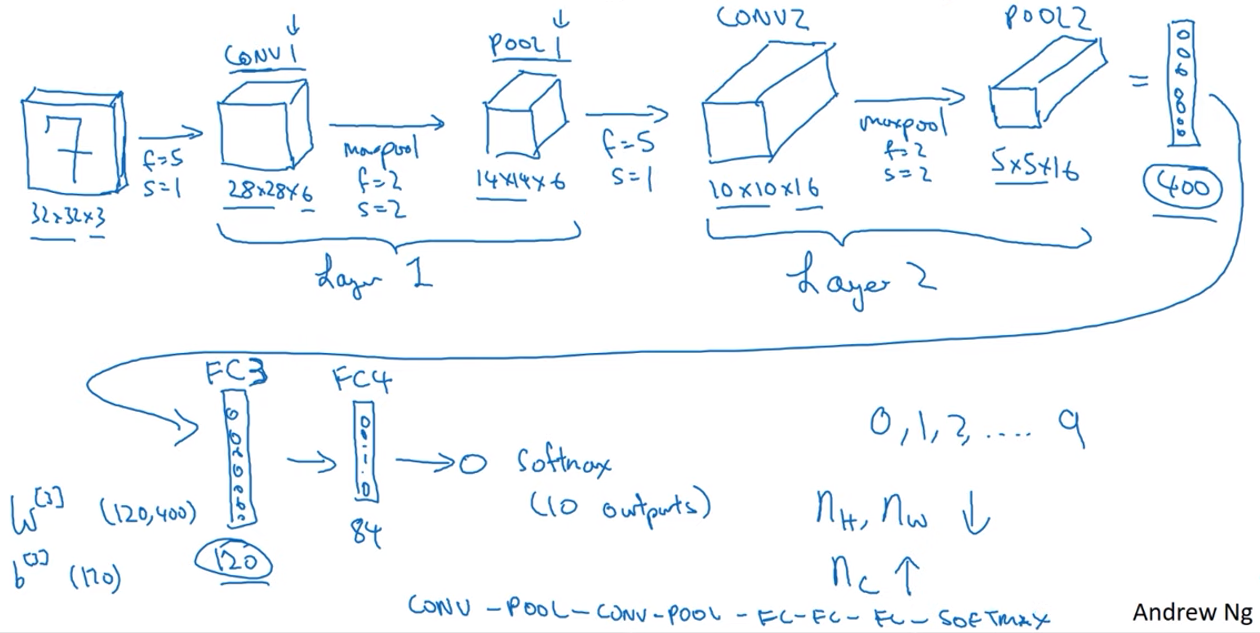

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Activation, Dropout

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [27]:
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [4]:
# normalize
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

# reshape
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

print(X_train.shape)
print(X_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [29]:
y_train.shape

(60000,)

In [30]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [32]:
np.eye(10)[y_train].astype(int)

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]])

In [5]:
from keras.utils.np_utils import to_categorical

#from tensorflow.keras.utils import to_categorical

In [38]:
to_categorical(y_train, num_classes=10)

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [6]:
y_train = to_categorical(y_train, num_classes=10).astype(int)

y_test = to_categorical(y_test, num_classes=10).astype(int)

In [7]:
inputshape = X_train.shape
inputshape

(60000, 28, 28, 1)

In [8]:
# build LeNet 
model = Sequential()
model.add(Conv2D(filters=6, kernel_size=5, strides=(1, 1), padding='valid',
                input_shape=inputshape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(filters=16, kernel_size=5, strides=(1, 1), padding='valid'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(400, activation='relu'))
model.add(Dense(120, activation='relu'))
model.add(Dense(84, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
def LeNet():
    model = Sequential()
    model.add(Conv2D(filters=6, kernel_size=5, strides=(1, 1), padding='valid',
                    input_shape=inputshape[1:]))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    model.add(Conv2D(filters=16, kernel_size=5, strides=(1, 1), padding='valid'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Activation('relu'))
    
    model.add(Flatten())
    model.add(Dense(400, activation='relu'))
    model.add(Dense(120, activation='relu'))
    model.add(Dense(84, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    return model

In [49]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 24, 24, 6)         156       
                                                                 
 activation (Activation)     (None, 24, 24, 6)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 6)        0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 16)          2416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 16)         0         
 2D)                                                             
                                                                 
 activation_1 (Activation)   (None, 4, 4, 16)         

In [50]:
hist = model.fit(X_train, y_train, batch_size=256, epochs=20,
                validation_split=0.2)

Epoch 1/20
188/188 [==============================] - 12s 57ms/step - loss: 0.4130 - accuracy: 0.8798 - val_loss: 0.1136 - val_accuracy: 0.9651
Epoch 2/20
188/188 [==============================] - 7s 39ms/step - loss: 0.0936 - accuracy: 0.9705 - val_loss: 0.0842 - val_accuracy: 0.9747
Epoch 3/20
188/188 [==============================] - 8s 43ms/step - loss: 0.0653 - accuracy: 0.9800 - val_loss: 0.0693 - val_accuracy: 0.9784
Epoch 4/20
188/188 [==============================] - 9s 47ms/step - loss: 0.0511 - accuracy: 0.9840 - val_loss: 0.0582 - val_accuracy: 0.9815
Epoch 5/20
188/188 [==============================] - 8s 43ms/step - loss: 0.0416 - accuracy: 0.9867 - val_loss: 0.0474 - val_accuracy: 0.9870
Epoch 6/20
188/188 [==============================] - 10s 51ms/step - loss: 0.0337 - accuracy: 0.9897 - val_loss: 0.0568 - val_accuracy: 0.9833
Epoch 7/20
188/188 [==============================] - 8s 44ms/step - loss: 0.0299 - accuracy: 0.9902 - val_loss: 0.0444 - val_accuracy: 0.98

### Train model with Data Augmentation, Learning Rate Reduction

In [10]:
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

In [11]:
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, factor=0.5, 
                                min_lr = 0.00001)

#x_train, x_val, ytrain, yval = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

data_gen = ImageDataGenerator(featurewise_center=False, samplewise_center=False,
                              featurewise_std_normalization=False, samplewise_std_normalization=False,
                              zca_whitening=False,
                              rotation_range=10, zoom_range=0.1,
                              width_shift_range=0.1, height_shift_range=0.1,
                              horizontal_flip=False, vertical_flip=False)

data_gen.fit(X_train)

In [14]:
model = LeNet()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

hist = model.fit(data_gen.flow(X_train, y_train, batch_size=256),
                          epochs=20, validation_data=(X_test, y_test), callbacks=[lr_reduction])

Epoch 1/20
235/235 [==============================] - 34s 140ms/step - loss: 0.5963 - accuracy: 0.8108 - val_loss: 0.1084 - val_accuracy: 0.9665 - lr: 0.0010
Epoch 2/20
235/235 [==============================] - 30s 128ms/step - loss: 0.1897 - accuracy: 0.9422 - val_loss: 0.0861 - val_accuracy: 0.9737 - lr: 0.0010
Epoch 3/20
235/235 [==============================] - 31s 132ms/step - loss: 0.1458 - accuracy: 0.9548 - val_loss: 0.0525 - val_accuracy: 0.9834 - lr: 0.0010
Epoch 4/20
235/235 [==============================] - 29s 125ms/step - loss: 0.1180 - accuracy: 0.9627 - val_loss: 0.0649 - val_accuracy: 0.9788 - lr: 0.0010
Epoch 5/20
235/235 [==============================] - 31s 133ms/step - loss: 0.0991 - accuracy: 0.9702 - val_loss: 0.0453 - val_accuracy: 0.9843 - lr: 0.0010
Epoch 6/20
235/235 [==============================] - 31s 132ms/step - loss: 0.0866 - accuracy: 0.9727 - val_loss: 0.0443 - val_accuracy: 0.9862 - lr: 0.0010
Epoch 7/20
235/235 [==============================] 

In [64]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

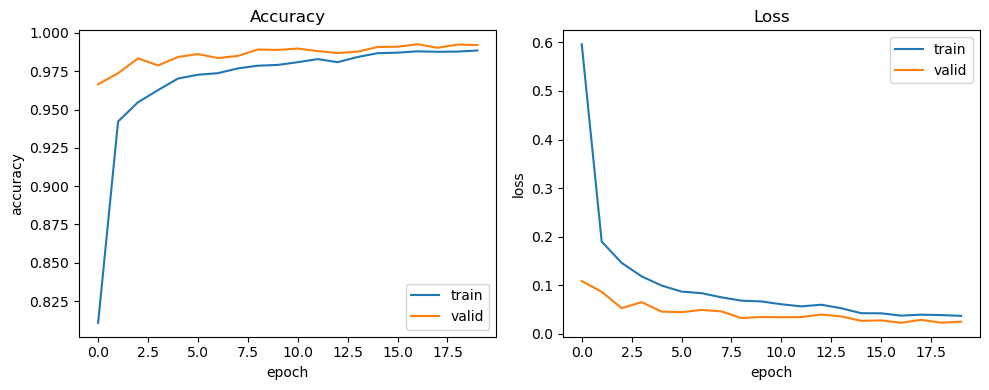

In [15]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])

plt.tight_layout()

In [16]:
preds = model.predict(X_test)

313/313 [==============================] - 1s 3ms/step


In [27]:
preds[:2]

array([[3.8925201e-09, 6.2982770e-07, 1.4455007e-06, 7.1137761e-06,
        1.7429832e-08, 1.7661241e-08, 1.1458533e-11, 9.9998957e-01,
        5.8453846e-08, 1.0747921e-06],
       [1.0181550e-08, 2.9182415e-06, 9.9999648e-01, 1.2969366e-10,
        2.6380320e-07, 3.0750216e-12, 2.0296578e-07, 2.1127404e-08,
        2.4300513e-09, 6.8912964e-09]], dtype=float32)

In [18]:
y_test[:3]

array([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]])

In [19]:
from sklearn.metrics import accuracy_score

In [20]:
y_preds = np.argmax(preds, axis=1)
y_true = np.argmax(y_test, axis=1)

accuracy_score(y_preds, y_true)

0.9921

In [21]:
y_true

array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

In [23]:
errors = y_preds != y_true
print('Number of predictions error:', errors.sum(), 'out of', len(y_true))
y_preds_error = preds[errors]   # probabilities

Number of predictions error: 79 out of 10000


In [24]:
y_preds_error[:1]

array([[3.38822399e-04, 1.25132094e-04, 7.51176178e-01, 1.87310104e-06,
        1.51067734e-01, 1.42583260e-04, 9.66964439e-02, 1.02545455e-05,
        4.40533855e-04, 4.72956344e-07]], dtype=float32)

In [33]:
y_preds_error_class = np.argmax(y_preds_error, axis=1)

In [34]:
y_preds_error_class

array([2, 7, 3, 4, 0, 2, 7, 7, 3, 4, 0, 9, 5, 1, 2, 4, 3, 6, 6, 3, 9, 3,
       4, 3, 9, 8, 4, 0, 3, 1, 5, 3, 9, 6, 8, 0, 9, 0, 8, 6, 8, 8, 4, 6,
       4, 7, 7, 5, 9, 7, 9, 8, 4, 5, 6, 3, 9, 6, 3, 8, 3, 9, 9, 9, 9, 7,
       7, 4, 7, 3, 2, 6, 6, 6, 5, 8, 7, 1, 6], dtype=int64)

In [35]:
y_true_error_class = y_true[errors]

In [36]:
y_true_error_class

array([4, 2, 5, 9, 6, 8, 2, 2, 5, 7, 4, 8, 6, 7, 7, 9, 5, 4, 0, 5, 8, 8,
       9, 5, 4, 5, 9, 2, 5, 6, 9, 2, 7, 0, 5, 6, 7, 5, 6, 4, 7, 9, 9, 4,
       9, 9, 2, 9, 3, 8, 8, 9, 9, 6, 9, 2, 4, 1, 5, 3, 5, 5, 5, 3, 8, 4,
       1, 9, 0, 5, 8, 0, 1, 0, 8, 1, 4, 6, 5], dtype=int64)

In [37]:
X_test_error = X_test[errors]

In [38]:
# probabilities of the wrongly predicted numbers
y_preds_error_prob = np.max(y_preds_error, axis=1)

In [39]:
y_preds_error_prob

array([0.7511762 , 0.9541135 , 0.532158  , 0.51974833, 0.5882258 ,
       0.6770326 , 0.97264874, 0.92715865, 0.99983597, 0.84264034,
       0.5828266 , 0.95167387, 0.8827878 , 0.70779186, 0.90757775,
       0.9309574 , 0.9760783 , 0.8437087 , 0.64841855, 0.6217718 ,
       0.6508889 , 0.9134129 , 0.98817766, 0.9545035 , 0.9901188 ,
       0.94546103, 0.9280458 , 0.99664795, 0.96331674, 0.5627353 ,
       0.7126303 , 0.91704005, 0.7912185 , 0.517678  , 0.5991046 ,
       0.97246885, 0.5637316 , 0.74495816, 0.5103261 , 0.9987329 ,
       0.7381218 , 0.61094975, 0.9570755 , 0.9713283 , 0.5314077 ,
       0.64671665, 0.9959942 , 0.55535907, 0.4482274 , 0.84384435,
       0.88208956, 0.9330183 , 0.6451809 , 0.5199372 , 0.84330195,
       0.66549057, 0.553661  , 0.8231148 , 0.95035124, 0.8122649 ,
       0.7916914 , 0.4437414 , 0.9229944 , 0.7775958 , 0.8052581 ,
       0.51416206, 0.71835124, 0.7164441 , 0.7046731 , 0.6744624 ,
       0.4682667 , 0.38974833, 0.93992436, 0.40945905, 0.99815

Now, we need to find y_true probability of the errors set

In [40]:
np.take(y_preds_error, indices=y_true_error_class, axis=1).shape

(79, 79)

In [46]:
np.take(y_preds_error, indices=[4], axis=1)

array([[1.51067734e-01],
       [5.09123265e-06],
       [4.28308994e-07],
       [5.19748330e-01],
       [1.26851117e-03],
       [5.99949408e-06],
       [2.87900843e-06],
       [2.02653013e-04],
       [1.16344987e-12],
       [8.42640340e-01],
       [2.96061069e-01],
       [2.15525785e-03],
       [9.62268154e-04],
       [2.41526240e-03],
       [1.69591309e-04],
       [9.30957377e-01],
       [2.21710280e-07],
       [1.05502725e-01],
       [2.58556838e-06],
       [1.60930392e-06],
       [9.76480097e-02],
       [4.71293930e-07],
       [9.88177657e-01],
       [9.86495260e-11],
       [9.71613266e-03],
       [2.73103615e-05],
       [9.28045809e-01],
       [5.94063795e-06],
       [2.44565167e-11],
       [4.67222556e-03],
       [8.90848984e-04],
       [1.62020370e-07],
       [2.22931034e-03],
       [1.10745132e-05],
       [2.80117396e-09],
       [2.27523324e-05],
       [8.08348763e-04],
       [1.87897589e-03],
       [4.07297164e-04],
       [1.20839768e-03],


In [48]:
df = pd.DataFrame(y_preds_error)
df

,0,1,2,3,4,5,6,7,8,9
0,3.388224e-04,1.251321e-04,7.511762e-01,1.873101e-06,1.510677e-01,1.425833e-04,9.669644e-02,1.025455e-05,0.000441,4.729563e-07
1,5.716767e-05,1.786503e-04,4.408203e-02,8.058113e-04,5.091233e-06,2.871327e-07,4.023638e-08,9.541135e-01,0.000609,1.485713e-04
2,2.167899e-08,1.302827e-04,9.483534e-08,5.321580e-01,4.283090e-07,4.674990e-01,5.742640e-07,5.033269e-09,0.000015,1.965958e-04
3,2.512551e-06,6.843197e-07,8.084740e-05,4.279287e-06,5.197483e-01,1.058430e-07,7.776864e-09,4.792817e-04,0.016658,4.630264e-01
4,5.882258e-01,6.435702e-08,9.265950e-05,1.505139e-05,1.268511e-03,9.151106e-04,4.010665e-01,2.060325e-06,0.007700,7.142231e-04
...,...,...,...,...,...,...,...,...,...,...
74,3.960380e-05,6.380867e-07,3.558713e-05,2.845426e-05,1.362902e-07,9.981533e-01,2.975521e-05,9.783539e-06,0.001693,9.489533e-06
75,2.429199e-04,3.583803e-01,4.221547e-03,1.875725e-04,4.116282e-03,7.368704e-05,4.292728e-05,1.039491e-01,0.520866,7.920003e-03
76,5.181843e-04,1.031592e-02,2.494151e-02,9.622013e-04,3.300190e-01,8.633182e-04,3.561372e-05,6.261662e-01,0.001221,4.957309e-03
77,3.207135e-04,7.775567e-01,5.489920e-02,1.013550e-01,3.898928e-05,1.130617e-02,5.376340e-02,5.387645e-04,0.000212,8.758807e-06


In [53]:
y_true_error

array([4, 2, 5, 9, 6, 8, 2, 2, 5, 7, 4, 8, 6, 7, 7, 9, 5, 4, 0, 5, 8, 8,
       9, 5, 4, 5, 9, 2, 5, 6, 9, 2, 7, 0, 5, 6, 7, 5, 6, 4, 7, 9, 9, 4,
       9, 9, 2, 9, 3, 8, 8, 9, 9, 6, 9, 2, 4, 1, 5, 3, 5, 5, 5, 3, 8, 4,
       1, 9, 0, 5, 8, 0, 1, 0, 8, 1, 4, 6, 5], dtype=int64)

In [59]:
y_true_error_prob = []
for i in range(len(df)):
    col = y_true_error[i]
    prob = df.iloc[i, col]
    y_true_error_prob.append(prob)

In [61]:
np.array(y_true_error_prob)

array([1.51067734e-01, 4.40820307e-02, 4.67498958e-01, 4.63026434e-01,
       4.01066482e-01, 1.97845936e-01, 2.69312486e-02, 7.73838954e-03,
       1.62446871e-04, 8.31951201e-02, 2.96061069e-01, 3.63198332e-02,
       2.82928981e-02, 2.09821478e-01, 8.84309262e-02, 6.86463565e-02,
       1.86792575e-02, 1.05502725e-01, 3.51573437e-01, 3.11191291e-01,
       1.88737690e-01, 6.92945942e-02, 1.04177538e-02, 4.52764742e-02,
       9.71613266e-03, 4.95487489e-02, 5.69501370e-02, 9.04682325e-04,
       3.66240852e-02, 4.26195741e-01, 1.93911493e-01, 7.80683607e-02,
       1.23445079e-01, 4.44626391e-01, 4.00743037e-01, 2.73349099e-02,
       4.23213422e-01, 1.14943087e-01, 2.65528828e-01, 1.20839768e-03,
       2.46489525e-01, 1.27185911e-01, 4.28961925e-02, 2.34516002e-02,
       4.68591452e-01, 3.34863752e-01, 3.16406926e-03, 4.00218099e-01,
       4.16947275e-01, 1.32640317e-01, 7.54941702e-02, 1.53905740e-02,
       3.47371846e-01, 4.23250139e-01, 3.07243746e-02, 3.32426995e-01,
      

In [47]:
np.diagonal(np.take(y_preds_error, indices=y_true_error, axis=1))

array([1.51067734e-01, 4.40820307e-02, 4.67498958e-01, 4.63026434e-01,
       4.01066482e-01, 1.97845936e-01, 2.69312486e-02, 7.73838954e-03,
       1.62446871e-04, 8.31951201e-02, 2.96061069e-01, 3.63198332e-02,
       2.82928981e-02, 2.09821478e-01, 8.84309262e-02, 6.86463565e-02,
       1.86792575e-02, 1.05502725e-01, 3.51573437e-01, 3.11191291e-01,
       1.88737690e-01, 6.92945942e-02, 1.04177538e-02, 4.52764742e-02,
       9.71613266e-03, 4.95487489e-02, 5.69501370e-02, 9.04682325e-04,
       3.66240852e-02, 4.26195741e-01, 1.93911493e-01, 7.80683607e-02,
       1.23445079e-01, 4.44626391e-01, 4.00743037e-01, 2.73349099e-02,
       4.23213422e-01, 1.14943087e-01, 2.65528828e-01, 1.20839768e-03,
       2.46489525e-01, 1.27185911e-01, 4.28961925e-02, 2.34516002e-02,
       4.68591452e-01, 3.34863752e-01, 3.16406926e-03, 4.00218099e-01,
       4.16947275e-01, 1.32640317e-01, 7.54941702e-02, 1.53905740e-02,
       3.47371846e-01, 4.23250139e-01, 3.07243746e-02, 3.32426995e-01,
      

In [62]:
# predicted probabilities of the true values in the errors set
y_true_error_prob = np.diagonal(np.take(y_preds_error, indices=y_true_error, axis=1))

# the difference between probability of the predicted label and the true label
delta = y_preds_error_prob - y_true_error_prob

In [63]:
delta_sorted = np.argsort(delta)   # sort ascending, get the indices

# top 10 errors
most_important_error = delta_sorted[-10:]

In [65]:
most_important_error

array([43, 16, 22, 24, 78, 46, 27, 74, 39,  8], dtype=int64)

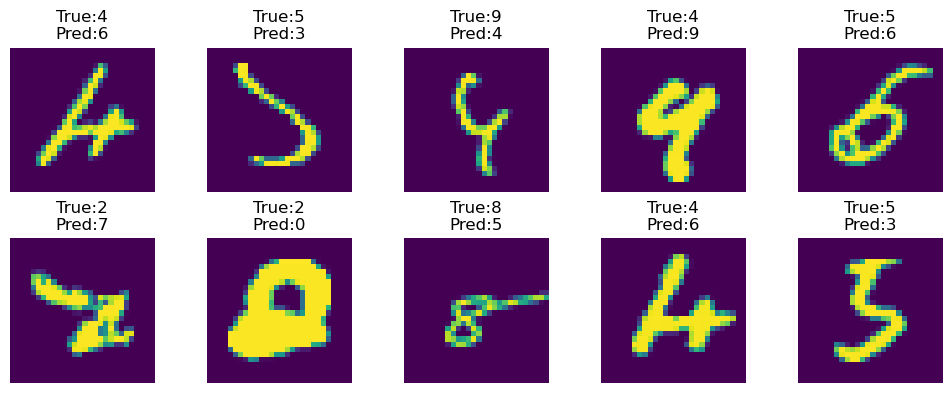

In [67]:
plt.figure(figsize=(10, 4))

for i in range(10):
    plt.subplot(2, 5, i+1)
    idx = most_important_error[i]
    plt.imshow(X_test_error[idx].reshape(28, 28))
    title = 'True:' + str(y_true_error_class[idx]) + '\nPred:' + str(y_preds_class[idx])
    plt.title(title, fontsize=12)
    plt.axis('off')
    
plt.tight_layout()